# Quantum Approximate Optimization Algorithm

This notebook introduces the API of the QAOA implementation available in the `qat.vsolve.qaoa` namespace.

We assume that the user is familiar with the algorithm itself and only detail the API of the library and the few algorithmical tools used for circuit synthesis.


## The CombinatorialProblem class

The interface of the library is concentrated into a single class `CombinatorialProblem`.

This class allows to:
* declare boolean variables
* add new clauses (i.e boolean formulae) to the final cost function

In [30]:
qat.opt?

Type:        module
String form: <module 'qat.opt' from '/scratch/x2241057/miniconda3/lib/python3.9/site-packages/qat/opt/__init__.so'>
File:        /scratch/x2241057/miniconda3/lib/python3.9/site-packages/qat/opt/__init__.so
Docstring:  
@authors Simon Martiel <simon.martiel@atos.net>
@internal
@copyright 2017-2020  Bull S.A.S.  -  All rights reserved.
           This is not Free or Open Source software.
           Please contact Bull SAS for details about its license.
           Bull - Rue Jean Jaurès - B.P. 68 - 78340 Les Clayes-sous-Bois

@file qat/opt/__init__.py
@brief
@namespace qat.opt


In [1]:
from qat.opt import CombinatorialProblem

# Declaring a fresh problem
my_problem = CombinatorialProblem()

# Declaring a new variable
v0 = my_problem.new_var()
v1 = my_problem.new_var()

# Or several variables
v_array = my_problem.new_vars(4)

# Variable are indexed starting from 0
print(v0, v1)
print(", ".join(str(v) for v in v_array))
# Clauses are built using boolean operators (|, &, ^, ~) and variables
print(v0 | v1)
print(v_array[0] & v_array[2])
print(v0 ^ v_array[0])
print(~v0)
print(~(v0 ^v_array[3] | v1))

# Clauses are added to a problem using the `add_clause` method
my_problem.add_clause(v0 ^ v1)
# Clauses can be weighted
my_problem.add_clause(v0 | v1, weight=2.)
for clause, weight in my_problem.clauses:
    print(clause, weight)

V(0) V(1)
V(2), V(3), V(4), V(5)
V(0) | V(1)
V(2) & V(4)
V(0) ^ V(2)
~ V(0)
~ ((V(0) ^ V(5)) | V(1))
V(0) ^ V(1) 1.0
V(0) | V(1) 2.0


By default, the class assumes that the described problem is a minimization problem.
It is possible to specify maximization problems by adding an argument in the constructor.

In practice, this will simply flip the sign of the cost function (or more precisely, its Hamiltonian encoding).

In [2]:
my_maximization_problem = CombinatorialProblem(maximization=True)

## From problem to variational Ansätze

Once a problem is declared, it is straightforward to construct a QAOA variational Ansatz from it: 

In [3]:
# We just need to specify a number of layers
my_problem = CombinatorialProblem()
variables = my_problem.new_vars(5)
for i in range(4):
    my_problem.add_clause(variables[i]^variables[i+1])

depth = 3
ansatz = my_problem.qaoa_ansatz(depth).circuit
ansatz.display()

/tmp/ipykernel_4040439/2047902235.py:9: DeprecationWarning: LAYOUT_BASIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Layout.BASIC instead.
  ansatz.display()
/tmp/ipykernel_4040439/2047902235.py:9: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  ansatz.display()


The variational ansatz is parametrized by abstract variables $\gamma_0,...,\gamma_{l-1}$ and $\beta_0,...,\beta_{l-1}$.

Variables can be listed as follows:

In [4]:
print("Variables:", ansatz.get_variables())

Variables: ['\\beta_{0}', '\\beta_{1}', '\\beta_{2}', '\\gamma_{0}', '\\gamma_{1}', '\\gamma_{2}']


You can see that their name is latex compliant, just for a nice display.

It is possible to bind these variables using their names:

In [12]:
import numpy as np
ansatz_gamma_0_pi = ansatz.bind_variables({"\\gamma_{0}": np.pi})
# or equivalently
ansatz_gamma_0_pi = ansatz(**{"\\gamma_{0}": np.pi})
ansatz_gamma_0_pi.display()

/tmp/ipykernel_4040439/2718893420.py:5: DeprecationWarning: LAYOUT_BASIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Layout.BASIC instead.
  ansatz_gamma_0_pi.display()
/tmp/ipykernel_4040439/2718893420.py:5: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  ansatz_gamma_0_pi.display()


## Observable synthesis

In order to be able to generate a QAOA Anstaz the Problem class first encodes each clause into a small Hamiltonian using the following inductive definition:
If boolean clauses are represented using the following grammar:

$exp := exp \lor exp | exp \land exp | exp \oplus exp | \neg exp | V$

Then the Hamiltonian encoding proceeds as follow:

$H(e_1\lor e_2) = H(e_1) + H(e_2) - H(e_1)H(e_2)$

$H(e_1 \land e_2) = H(e_1) * H(e_2)$

$H(e1 \oplus e2) = H(e1) + H(e2) - 2H(e1)H(e2)$

$H(\neg e) = 1 - H(e)$

$H(V(i)) = \frac{1 - \sigma_i^z}{2}$

The complete encoding is then obtained by summing these smaller Hamiltonian (with some eventual coefficients to account for the weights). 

Finally, if the problem is a maximization problem, the sign of the Hamiltonian is flipped, so that the problem becomes a minimization problem.

The Hamiltonian can be obtained using the `.get_observable()` method:

In [6]:
my_problem = CombinatorialProblem()
variables = my_problem.new_vars(5)
for i in range(4):
    my_problem.add_clause(variables[i]^variables[i+1])
print("Minimization:\n", my_problem.get_observable())

my_problem = CombinatorialProblem(maximization=True)
variables = my_problem.new_vars(5)
for i in range(4):
    my_problem.add_clause(variables[i]^variables[i+1])
print("Maximization:\n",my_problem.get_observable())

Minimization:
 2.0 * I^5 +
-0.5 * (ZZ|[0, 1]) +
-0.5 * (ZZ|[1, 2]) +
-0.5 * (ZZ|[2, 3]) +
-0.5 * (ZZ|[3, 4])
Maximization:
 -2.0 * I^5 +
0.5 * (ZZ|[0, 1]) +
0.5 * (ZZ|[1, 2]) +
0.5 * (ZZ|[2, 3]) +
0.5 * (ZZ|[3, 4])


## Circuit synthesis

Once the observable is generated, there are two distinct circuit synthesis algorithm that can be used to extract an Ansatz from the cost Hamiltonian:

* The "default" algorithm naively produces a subcircuit per term in the Hamiltonian for each layer of the Ansatz. For most applications, this algorithm is enough and will provide a relatively efficient Ansatz.

* The "coloring" heuristics does pretty much the same but optimizes the ordering of the terms in order to minimize circuit depth.

* The "gray_synth" heuristics uses Amy et al phase polynomial synthesis algorithm to implement the entangling portion of the Ansatz. This can help reduce the CNOT count of the resulting circuit.

In [7]:
my_problem = CombinatorialProblem()
n = 7
variables = my_problem.new_vars(n)
for i in range(n - 2):
    my_problem.add_clause(variables[i] ^ variables[i+1] ^ variables[i+2])
print("Cost Hamiltonian:\n", my_problem.get_observable())
circuit1 = my_problem.qaoa_ansatz(1, strategy="default").circuit
circuit2 = my_problem.qaoa_ansatz(1, strategy="coloring").circuit
circuit3 = my_problem.qaoa_ansatz(1, strategy="gray_synth").circuit
circuit1.display()
circuit2.display()
circuit3.display()

Cost Hamiltonian:
 2.5 * I^7 +
-0.5 * (ZZZ|[0, 1, 2]) +
-0.5 * (ZZZ|[1, 2, 3]) +
-0.5 * (ZZZ|[2, 3, 4]) +
-0.5 * (ZZZ|[3, 4, 5]) +
-0.5 * (ZZZ|[4, 5, 6])


/tmp/ipykernel_4040439/2352692348.py:10: DeprecationWarning: LAYOUT_BASIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Layout.BASIC instead.
  circuit1.display()
/tmp/ipykernel_4040439/2352692348.py:10: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  circuit1.display()


/tmp/ipykernel_4040439/2352692348.py:11: DeprecationWarning: LAYOUT_BASIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Layout.BASIC instead.
  circuit2.display()
/tmp/ipykernel_4040439/2352692348.py:11: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  circuit2.display()


/tmp/ipykernel_4040439/2352692348.py:12: DeprecationWarning: LAYOUT_BASIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Layout.BASIC instead.
  circuit3.display()
/tmp/ipykernel_4040439/2352692348.py:12: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  circuit3.display()


# Running a full algorithm - MaxCut

The `qat.vsolve.qaoa` namespace also contains a very simple wrapper to produce problems describing a MAXCUT instance.

The class can be instantiated using a networkx graph:



In [18]:
MaxCut

qat.vsolve.qaoa.__init__.MaxCut

MaxCut:
 10 variables, 23 clauses


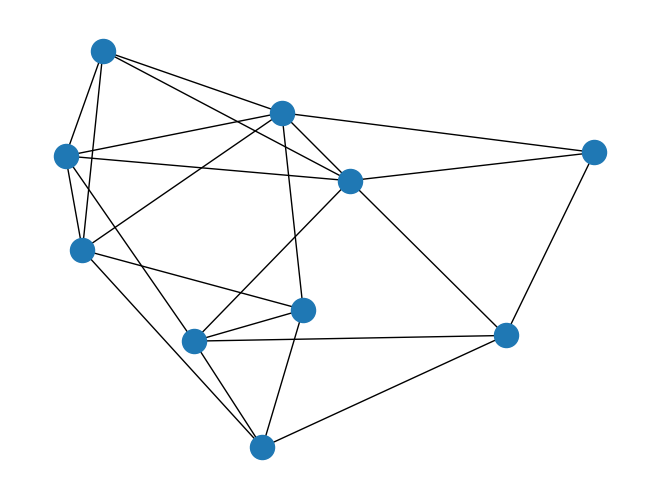

In [8]:
import networkx as nx

graph = nx.generators.random_graphs.erdos_renyi_graph(10, 0.5)
nx.draw(graph)
from qat.vsolve.qaoa import MaxCut
problem = MaxCut(graph)
print(problem)

We can now make use of a variational plugin to optimize a QAOA Ansatz:

In [9]:
from qat.qpus import get_default_qpu
from qat.plugins import ScipyMinimizePlugin
qpu = get_default_qpu()
stack = ScipyMinimizePlugin(method="COBYLA",
                            tol=1e-5, 
                            options={"maxiter": 200}) | qpu
# We can directly call the to_job method of the Problem class to pack an Ansatz and 
# the cost observable in a single abstract Job
job = problem.qaoa_ansatz(3) # Here 3 is the depth of the Ansatz
result = stack.submit(job)
print("Final energy:", result.value)

Final energy: -14.48148908737013


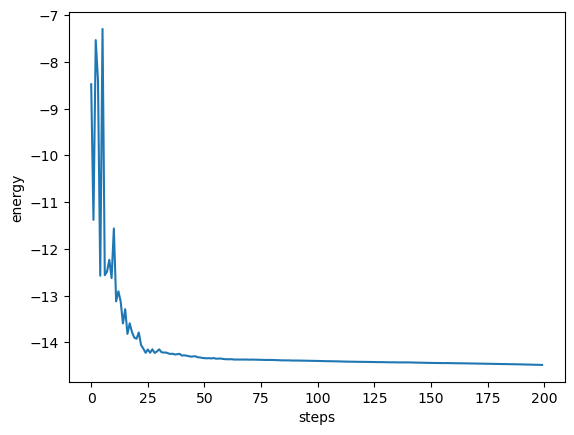

In [10]:
import matplotlib.pyplot as plt
plt.plot(eval(result.meta_data["optimization_trace"]))
plt.xlabel("steps")
plt.ylabel("energy")
plt.show()

### Printing the most probable states

We now print the most probable states of the distribution corresponding to the optimized QAOA parameters:

In [20]:
#Binding the variables:
sol_job = job(**eval(result.meta_data["parameter_map"]))

#Rerunning in 'SAMPLE' mode to get the most probable states:
sampling_job = sol_job.circuit.to_job(nbshots = 100)

Most probable states are:
|0011010011> 20.00%
|0010111001> 10.00%
|0011100111> 10.00%
|0110000110> 10.00%
|1110101100> 10.00%
|1001000110> 10.00%
|1100010101> 10.00%
|1100001110> 10.00%
|0010010010> 10.00%
And as bitstrings:
('0011010011',) 20.00%
('0010111001',) 10.00%
('0011100111',) 10.00%
('0110000110',) 10.00%
('1110101100',) 10.00%
('1001000110',) 10.00%
('1100010101',) 10.00%
('1100001110',) 10.00%
('0010010010',) 10.00%
Most probable cut: {0, 1, 3, 6, 8} {2, 4, 5, 7, 9}


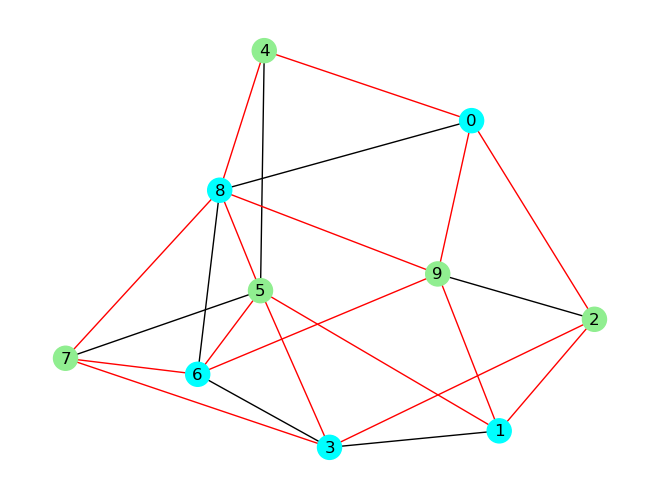

In [26]:
#Binding the variables:
sol_job = job(**eval(result.meta_data["parameter_map"]))

#Rerunning in 'SAMPLE' mode to get the most probable states:
sampling_job = sol_job.circuit.to_job(nbshots = 10)

sol_res = qpu.submit(sampling_job)
print("Most probable states are:")
for sample in sol_res:
    if sample.probability > 0.05:
        print(sample.state, "{:.2f}%".format(100 * sample.probability))
        
# We can also directly cast states into bitstrings for practical use:
print("And as bitstrings:")
for sample in sol_res:
    if sample.probability > 0.05:
        print(sample.state.value, "{:.2f}%".format(100 * sample.probability))
        
# Emulating a reasonnable setup:
# Drawing 1024 cuts
sampling_job = sol_job.circuit.to_job(nbshots=1024)
sol_res = qpu.submit(sampling_job)
# Picking the most probable cut
best_cut = max([(s.state.value[0], s.probability) for s in sol_res], key=lambda s: s[1])[0]
print(
    "Most probable cut:", 
    set(i for i in graph.nodes() if best_cut[i] == '1'), 
    set(i for i in graph.nodes() if best_cut[i] == '0')
)
# Plotting the cut nicely
nx.draw(
    graph, labels={i: str(i) for i in graph.nodes()},
    node_color=["cyan" if b == '1' else 'lightgreen' for b in best_cut],
    edge_color=['red' if best_cut[a] != best_cut[b] else 'black' for a, b in graph.edges()]
)